In [4]:
# fix for keras v3.0 update
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' 

# tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# python based
import random
from pathlib import Path
import time
import argparse
import json
import submitit
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# custom code
from OptimizedDataGenerator import OptimizedDataGenerator
from loss import *
from models import *

In [5]:
# set gpu growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

output_directory = Path("./training_output").resolve()
batch_size = 500
val_batch_size = 500

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
os.makedirs(output_directory, exist_ok=True)
print(output_directory)

# paths
data_directory_path = "/home/elizahoward/cmspix28-mc-sim/minbiasDataSet1/"
labels_directory_path = "/home/elizahoward/cmspix28-mc-sim/minbiasDataSet1/"
    
# create tf records directory
stamp = '%08x' % random.randrange(16**8)
tfrecords_dir_train = Path(output_directory, f"tfrecords_train_{stamp}").resolve()
tfrecords_dir_validation = Path(output_directory, f"tfrecords_validation_{stamp}").resolve()
if not os.path.exists(tfrecords_dir_train):
    os.mkdir(tfrecords_dir_train)
    os.mkdir(tfrecords_dir_validation)

# training generator
start_time = time.time()
training_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = labels_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = batch_size,
    to_standardize= False,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    save=True,
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_train,
)
print("--- Training generator %s seconds ---" % (time.time() - start_time))

data_directory_path = "/home/elizahoward/cmspix28-mc-sim/minbiasDataSet2/"
labels_directory_path = "/home/elizahoward/cmspix28-mc-sim/minbiasDataSet2/"

start_time = time.time()
validation_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = labels_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = val_batch_size,
    to_standardize= False,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_validation,
)
print("--- Validation generator %s seconds ---" % (time.time() - start_time))

/home/elizahoward/smart-pixels-ml/training_output
Directory /home/elizahoward/smart-pixels-ml/training_output/tfrecords_train_8779a829 is removed...


Saving batches as TFRecords: 100%|██████████| 50/50 [00:02<00:00, 18.59it/s]


--- Training generator 8.194495439529419 seconds ---
Directory /home/elizahoward/smart-pixels-ml/training_output/tfrecords_validation_8779a829 is removed...


Saving batches as TFRecords: 100%|██████████| 11/11 [00:01<00:00, 10.70it/s]


--- Validation generator 6.157037019729614 seconds ---


In [6]:
 # compiles model
n_filters = 5 # model number of filters
pool_size = 3 # model pool size
learning_rate = 0.001
start_time = time.time()
model=CreateModel(shape=(13,21,2), n_filters=n_filters, pool_size=pool_size)
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=custom_loss)

print("--- Model create and compile %s seconds ---" % (time.time() - start_time))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         33        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 6, 5)           0     

In [7]:
learning_rate = 0.1
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=custom_loss)

In [8]:
epochs = 25
early_stopping_patience = 50

# launch quick training once gpu is available
es = EarlyStopping(
        patience=early_stopping_patience,
        restore_best_weights=True
)
    
# checkpoint path
checkpoint_filepath = Path(output_directory, 'weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5').resolve()
mcp = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True,
)

# train
history = model.fit(x=training_generator,
                        validation_data=validation_generator,
                        callbacks=[mcp],
                        epochs=epochs,
                        shuffle=False, # shuffling now occurs within the data-loader
                        verbose=1)
    
# clean up tf records
#shutil.rmtree(tfrecords_dir_train)
#shutil.rmtree(tfrecords_dir_validation)

Epoch 1/25
50/50 [==============================] - 15s 68ms/step - loss: 9523.6084 - val_loss: 7037.9258
Epoch 2/25
50/50 [==============================] - 3s 52ms/step - loss: 9521.6240 - val_loss: 7037.8833
Epoch 3/25
50/50 [==============================] - 3s 52ms/step - loss: 9521.6025 - val_loss: 7037.8628
Epoch 4/25
50/50 [==============================] - 3s 53ms/step - loss: 9521.5986 - val_loss: 7037.8955
Epoch 5/25
50/50 [==============================] - 3s 54ms/step - loss: 9521.5957 - val_loss: 7037.9419
Epoch 6/25
50/50 [==============================] - 3s 53ms/step - loss: 9521.5957 - val_loss: 7037.8950
Epoch 7/25
50/50 [==============================] - 3s 54ms/step - loss: 9521.5977 - val_loss: 7037.8613
Epoch 8/25
50/50 [==============================] - 3s 54ms/step - loss: 9521.5947 - val_loss: 7037.8779
Epoch 9/25
50/50 [==============================] - 3s 54ms/step - loss: 9521.5928 - val_loss: 7037.8550
Epoch 10/25
50/50 [==============================] - 3

In [ ]:
#model.load_weights("/home/elizahoward/smart-pixels-ml/training_output/weights.08-t-12.89-v-49.49.hdf5")

In [6]:
p_test = model.predict(validation_generator)

11/11 [==============================] - 1s 54ms/step


In [7]:
complete_truth = None
for _, y in tqdm(validation_generator):
        if complete_truth is None:
            complete_truth = y
        else:
            complete_truth = np.concatenate((complete_truth, y), axis=0)

100%|██████████| 11/11 [00:00<00:00, 29.31it/s]


In [8]:
maxval=1e9
minval=1e-9

# creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])
df['x'] *= 75
df['y'] *= 18.75
df['cotA'] *= 8
df['cotB'] *= 0.5

# stores all true values in same matrix as xtrue, ytrue, etc.
df['xtrue'] = complete_truth[:,0]*75
df['ytrue'] = complete_truth[:,1]*18.75
df['cotAtrue'] = complete_truth[:,2]*8
df['cotBtrue'] = complete_truth[:,3]*0.5
df['M11'] = minval+tf.math.maximum(df['M11'], 0)
df['M22'] = minval+tf.math.maximum(df['M22'], 0)
df['M33'] = minval+tf.math.maximum(df['M33'], 0)
df['M44'] = minval+tf.math.maximum(df['M44'], 0)

df['sigmax'] = abs(df['M11'])
df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)

# calculates residuals for x, y, cotA, cotB
residualsx = np.abs(df['xtrue'] - df['x'])
residualsy = np.abs(df['ytrue'] - df['y'])
residualsA = np.abs(df['cotAtrue'] - df['cotA'])
residualsB = np.abs(df['cotBtrue'] - df['cotB'])

# stores results as csv
df.to_csv("test_4x4.csv",header=True,index=False)

In [11]:
df['x']

0       8.468628
1       9.631348
2       9.494019
3       4.412842
4       0.187683
          ...   
2602    2.307129
2603    0.563049
2604    1.657104
2605    3.776550
2606   -1.135254
Name: x, Length: 2607, dtype: float32

In [9]:
# x
xmean, xstd = (np.mean(residualsx),np.std(residualsx))
print(f"mean and std residuals for x-midplane: ({xmean},{xstd})")
# y
ymean, ystd = (np.mean(residualsy),np.std(residualsy))
print(f"mean and std residuals for y-midplane: ({ymean},{ystd})")
# cotA
cotAmean, cotAstd = (np.mean(residualsA),np.std(residualsA))
print(f"mean and std residuals for cot(alpha): ({cotAmean},{cotAstd})")
# cotB
cotBmean, cotBstd = (np.mean(residualsB),np.std(residualsB))
print(f"mean and std residuals for cot(beta): ({cotBmean},{cotBstd})")


mean and std residuals for x-midplane: (37.84352111816406,22.221717834472656)
mean and std residuals for y-midplane: (9.676804542541504,5.566128730773926)
mean and std residuals for cot(alpha): (3.315249443054199,2.7996439933776855)
mean and std residuals for cot(beta): (0.14212627708911896,0.09247184544801712)


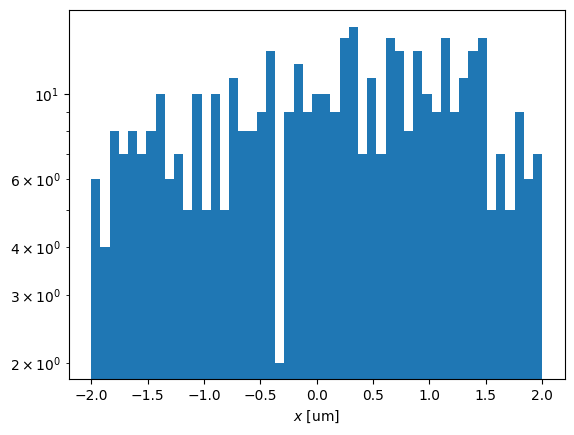

In [10]:
plt.hist(p_test[:,0],bins=np.linspace(-2,2,50))
plt.yscale('log')
plt.xlabel(r'$x$ [um]')

#save_fig_path = os.path.join(base_dir, 'x_dist.png')
#plt.savefig(save_fig_path)

plt.show()

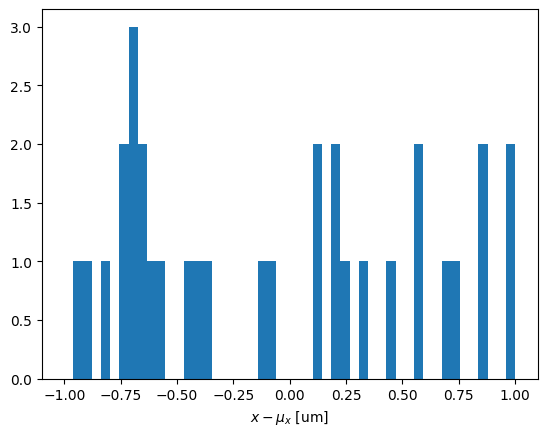

In [22]:
plt.hist(residuals,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')

#save_fig_path = os.path.join(base_dir, 'x_res_dist.png')
#plt.savefig(save_fig_path)

plt.show()

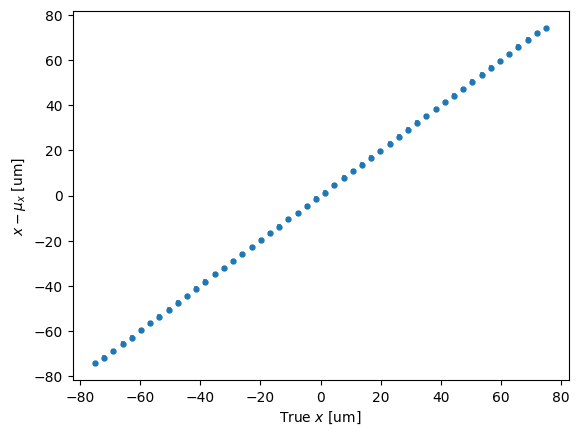

In [26]:
x = sns.regplot(x=df['xtrue'], y=(df['xtrue']-df['x']), x_bins=np.linspace(-75,75,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

#save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
#plt.savefig(save_fig_path)

plt.show()

In [25]:
min(df['xtrue'])

-74.98991394042969

In [14]:
np.linspace(-1,1,50)

array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
       -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
       -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
       -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
       -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
        0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
        0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.3877551 ,
        0.42857143,  0.46938776,  0.51020408,  0.55102041,  0.59183673,
        0.63265306,  0.67346939,  0.71428571,  0.75510204,  0.79591837,
        0.83673469,  0.87755102,  0.91836735,  0.95918367,  1.        ])

In [9]:
df['xtrue']

0       1.953401e-06
1      -1.147367e-06
2       6.652156e-06
3      -3.238392e-07
4      -2.245828e-06
            ...     
8552    4.094036e-07
8553   -1.305013e-06
8554    3.859511e-07
8555   -1.912578e-07
8556    5.552644e-09
Name: xtrue, Length: 8557, dtype: float32

In [10]:
df['x']

0       0.096313
1      -0.005310
2       0.018250
3       0.063293
4       0.045288
          ...   
8552    0.069336
8553    0.022278
8554    0.065857
8555    0.071167
8556    0.081055
Name: x, Length: 8557, dtype: float32

<tf.Tensor: shape=(500, 4), dtype=float32, numpy=
array([[ 1.9534011e-06,  3.1854577e-06, -5.2159536e-01,  3.7237611e-02],
       [-1.1473669e-06, -1.5861623e-06,  5.2710271e-01, -1.5139881e-01],
       [ 6.6521561e-06, -2.1257800e-07,  6.6928500e-01,  2.1744016e-01],
       ...,
       [-1.2793189e-06,  1.2136934e-07, -8.4981728e-01,  4.7479909e-02],
       [ 1.0449221e-06,  6.7087751e-07,  1.0046810e+00, -8.0120504e-02],
       [ 1.1644505e-05, -3.8532557e-06,  1.0196804e+00, -4.8853710e-01]],
      dtype=float32)>